In [39]:
#import required packages
import pandas as pd
import seaborn as sns
import re
import nltk
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.svm import SVC #Support Vector Classifier
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
import pickle
%matplotlib inline

In [40]:
wine = pd.read_csv('../Data/winemag-data-130k-v2.csv', sep=',')

In [41]:
wine.head()

,id,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,1,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,2,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,3,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,4,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,5,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [42]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129970 entries, 0 to 129969
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     129970 non-null  int64  
 1   country                129907 non-null  object 
 2   description            129970 non-null  object 
 3   designation            92506 non-null   object 
 4   points                 129970 non-null  int64  
 5   price                  120974 non-null  float64
 6   province               129907 non-null  object 
 7   region_1               108723 non-null  object 
 8   region_2               50510 non-null   object 
 9   taster_name            103726 non-null  object 
 10  taster_twitter_handle  98757 non-null   object 
 11  title                  129970 non-null  object 
 12  variety                129969 non-null  object 
 13  winery                 129970 non-null  object 
dtypes: float64(1), int64(2), object(11)


In [43]:
wine.isnull().sum()

id                           0
country                     63
description                  0
designation              37464
points                       0
price                     8996
province                    63
region_1                 21247
region_2                 79460
taster_name              26244
taster_twitter_handle    31213
title                        0
variety                      1
winery                       0
dtype: int64

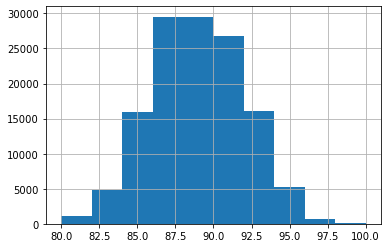

In [44]:
wine.points.hist()

In [45]:
wine.describe()

,id,points,price
count,129970.000000,129970.000000,120974.000000
mean,64985.500000,88.447095,35.363268
std,37519.251581,3.039703,41.022366
min,1.000000,80.000000,4.000000
25%,32493.250000,86.000000,17.000000
50%,64985.500000,88.000000,25.000000
75%,97477.750000,91.000000,42.000000
max,129970.000000,100.000000,3300.000000


In [46]:
print("Length of dataframe before duplicates are removed:", len(wine))

Length of dataframe before duplicates are removed: 129970


In [47]:
wine_data_clean = wine[wine.duplicated('description', keep=False)]
print("Length of dataframe after duplicates are removed:", len(wine_data_clean))

Length of dataframe after duplicates are removed: 20026


In [48]:
#preprocessing
#bins = (2, 91, 100)
# group_names = ['bad', 'good']
# wine['points'] = pd.cut(wine['points'],bins=bins, labels=group_names)
# wine['points'].unique()

In [49]:
#simplify model
wine_simple_df=wine_data_clean[['description', 'points']]
wine_simple_df.head()

,description,points
9,This has great depth of flavor with its fresh ...,87
10,"Soft, supple plum envelopes an oaky structure ...",87
11,"This is a dry wine, very spicy, with a tight, ...",87
12,"Slightly reduced, this wine offers a chalky, t...",87
13,This is dominated by oak and oak-driven aromas...,87


In [50]:
wine_simple_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20026 entries, 9 to 129912
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   description  20026 non-null  object
 1   points       20026 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 469.4+ KB


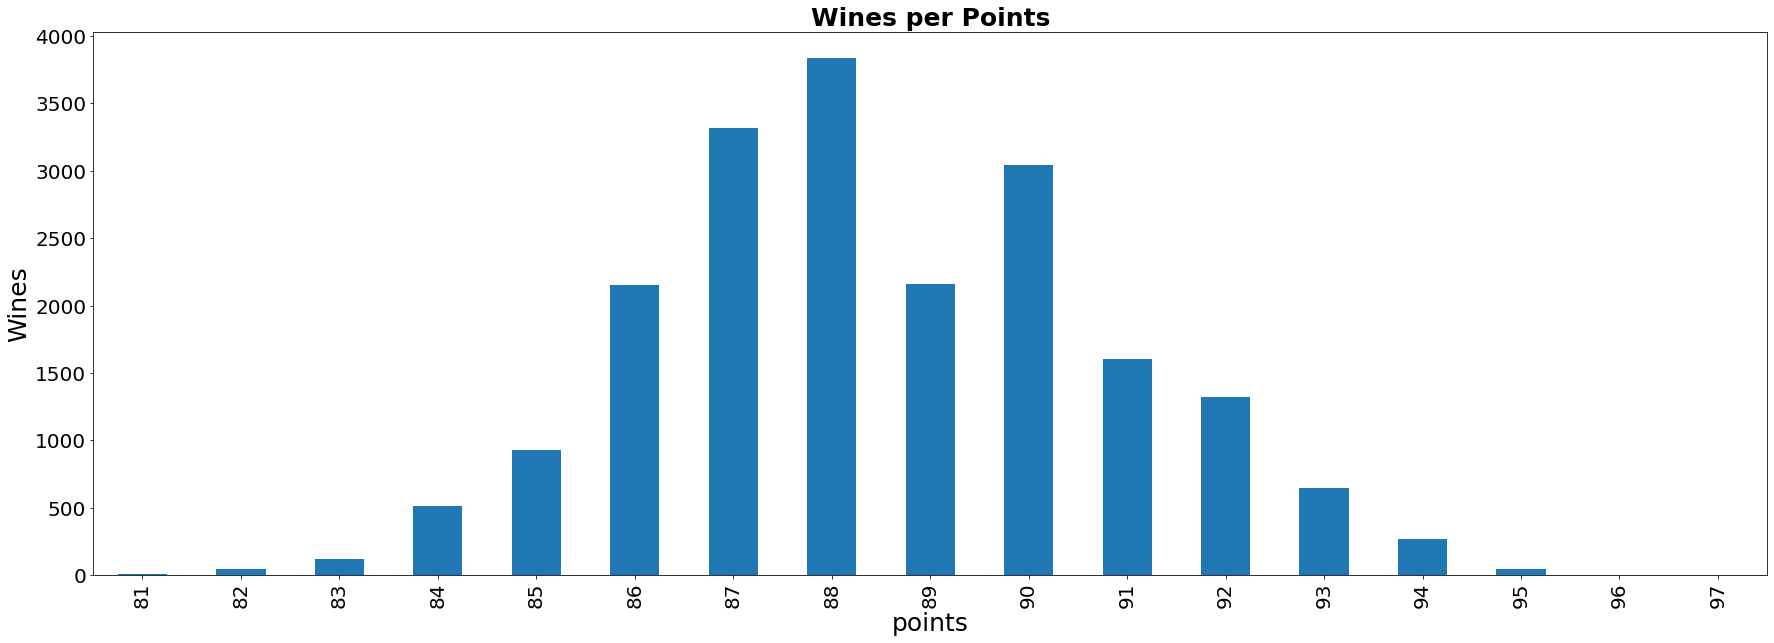

In [51]:
fig, ax = plt.subplots(figsize=(30,10))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.set_title('Wines per Points', fontweight='bold', size=25)
ax.set_ylabel('Wines', fontsize = 25)
ax.set_xlabel('Points',fontsize = 25)
wine_simple_df.groupby(['points']).count()['description'].plot(ax=ax, kind='bar')

In [52]:
def point_weight(points):
    if points < 86:
        return 1
    elif points >= 86 and points < 89:
        return 2
    elif points >= 89 and points < 92:
        return 3
    else:
        return 4

In [53]:
wine_simple_df = wine_simple_df.assign(point_weights = wine_simple_df['points'].apply(point_weight))
wine_simple_df.head()

,description,points,point_weights
9,This has great depth of flavor with its fresh ...,87,2
10,"Soft, supple plum envelopes an oaky structure ...",87,2
11,"This is a dry wine, very spicy, with a tight, ...",87,2
12,"Slightly reduced, this wine offers a chalky, t...",87,2
13,This is dominated by oak and oak-driven aromas...,87,2


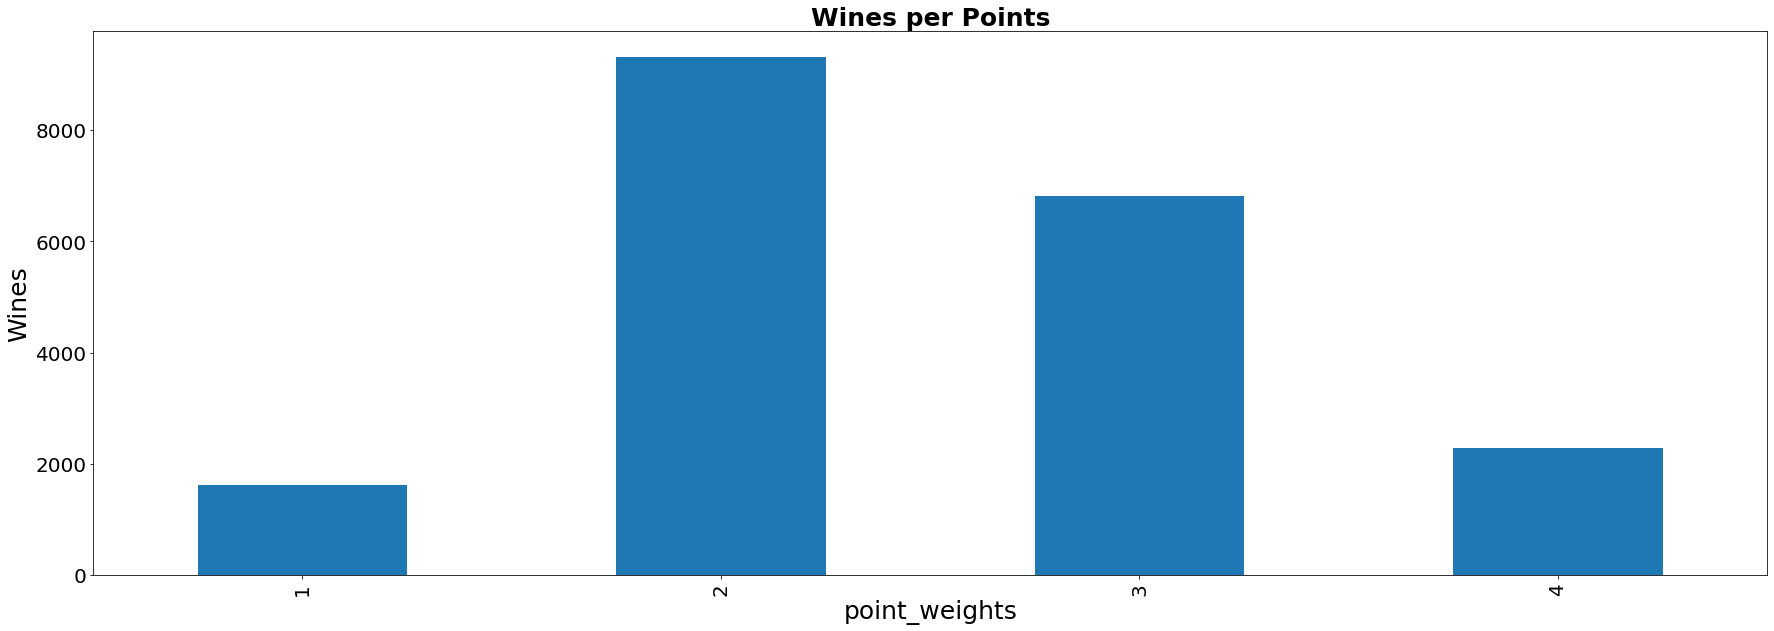

In [54]:
fig, ax = plt.subplots(figsize=(30,10))
plt.xticks(fontsize=20, rotation='horizontal')
plt.yticks(fontsize=20, rotation='horizontal')
ax.set_title('Wines per Points', fontweight='bold', size=25)
ax.set_ylabel('Wines', fontsize = 25)
ax.set_xlabel('Point Weights',fontsize = 25)
wine_simple_df.groupby(['point_weights']).count()['description'].plot(ax=ax, kind='bar')

In [55]:
def cleanText(text):
#    text=text.lower()

    # remove all single characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)

    # Remove single characters from the start
    text = re.sub(r'\^[a-zA-Z]\s+', ' ', text) 

    # Substituting multiple spaces with single space
    text = re.sub(r'\s+', ' ', text, flags=re.I)

    # Removing prefixed 'b'
    text = re.sub(r'^b\s+', '', text)

    # Converting to Lowercase
    text = text.lower()

    return text 

In [56]:
X = wine_simple_df['description']
X = X.apply(cleanText)

In [57]:
X.head()

9     this has great depth of flavor with its fresh ...
10    soft, supple plum envelopes an oaky structure ...
11    this is dry wine, very spicy, with tight, taut...
12    slightly reduced, this wine offers chalky, tan...
13    this is dominated by oak and oak-driven aromas...
Name: description, dtype: object

In [58]:
y = wine_simple_df['point_weights']
vectorizer = CountVectorizer(stop_words='english',max_features=1500)
vectorizer.fit(X)

CountVectorizer(max_features=1500, stop_words='english')

In [59]:
X = vectorizer.transform(X)
print('Shape of Sparse Matrix: ', X.shape)
print('Amount of Non-Zero occurrences: ', X.nnz)
# Percentage of non-zero values
density = (100.0 * X.nnz / (X.shape[0] * X.shape[1]))
print('Density: {}'.format((density)))

Shape of Sparse Matrix:  (20026, 1500)
Amount of Non-Zero occurrences:  411332
Density: 1.3693265421618563


3 models
1. Random Forest Classifier
2. Support Vector Classifier
3. Neural Network (MLPClassifier)

In [60]:
#train and test splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101)

Random Forest Classifier

In [61]:
rfc_classifier = RandomForestClassifier()
rfc_classifier.fit(X_train, y_train)
rfc_pred = rfc_classifier.predict(X_test)

In [62]:
print(confusion_matrix(y_test,rfc_pred))

[[162  11   0   0]
 [  0 869  20   0]
 [  0  32 668   0]
 [  0   4  10 227]]


In [63]:
print(classification_report(y_test,rfc_pred))

              precision    recall  f1-score   support

           1       1.00      0.94      0.97       173
           2       0.95      0.98      0.96       889
           3       0.96      0.95      0.96       700
           4       1.00      0.94      0.97       241

    accuracy                           0.96      2003
   macro avg       0.98      0.95      0.96      2003
weighted avg       0.96      0.96      0.96      2003



In [64]:
print(accuracy_score(y_test, rfc_pred))

0.9615576635047429


In [65]:
with open('./Saved/wine_model_rfc', 'wb') as rfc_picklefile:
    pickle.dump(rfc_classifier,rfc_picklefile)

Support Vector Machine/SVM Classifier (for smaller numbers)

In [66]:
clf_classifier=svm.SVC()
clf_classifier.fit(X_train, y_train)
clf_pred = clf_classifier.predict(X_test)

In [67]:
print(confusion_matrix(y_test,clf_pred))

[[ 76  91   6   0]
 [  2 836  48   3]
 [  0  99 591  10]
 [  0  26  30 185]]


In [68]:
print(classification_report(y_test,clf_pred))

              precision    recall  f1-score   support

           1       0.97      0.44      0.61       173
           2       0.79      0.94      0.86       889
           3       0.88      0.84      0.86       700
           4       0.93      0.77      0.84       241

    accuracy                           0.84      2003
   macro avg       0.89      0.75      0.79      2003
weighted avg       0.86      0.84      0.84      2003



In [69]:
print(accuracy_score(y_test, clf_pred))

0.8427358961557664


In [70]:
with open('./Saved/wine_model_clf', 'wb') as clf_picklefile:
    pickle.dump(clf_classifier,clf_picklefile)

Neural Network

In [71]:
mlpc_classifier=MLPClassifier(hidden_layer_sizes=(11,11,11),max_iter=500)
mlpc_classifier.fit(X_train, y_train)
mlpc_pred=mlpc_classifier.predict(X_test)

In [72]:
print(confusion_matrix(y_test,mlpc_pred))

[[164   9   0   0]
 [ 14 843  30   2]
 [  2  30 654  14]
 [  0   2  10 229]]


In [73]:
print(classification_report(y_test, mlpc_pred))

              precision    recall  f1-score   support

           1       0.91      0.95      0.93       173
           2       0.95      0.95      0.95       889
           3       0.94      0.93      0.94       700
           4       0.93      0.95      0.94       241

    accuracy                           0.94      2003
   macro avg       0.94      0.95      0.94      2003
weighted avg       0.94      0.94      0.94      2003



In [74]:
print(accuracy_score(y_test, mlpc_pred))

0.9435846230654019


Save the Neural Netowrk model to run later

In [75]:
with open('./Saved/wine_model_mlpc', 'wb') as mlpc_picklefile:
    pickle.dump(mlpc_classifier,mlpc_picklefile)

Load and Re-run the Neural Network model at a later time

In [76]:
#load
with open('./Saved/wine_model_mlpc', 'rb') as mlpc_training_model:
    model = pickle.load(mlpc_training_model)
#run    
mlpc_pred2 = model.predict(X_test)

#print reports
print(confusion_matrix(y_test, mlpc_pred2))
print(classification_report(y_test, mlpc_pred2))
print(accuracy_score(y_test, mlpc_pred2)) 

[[164   9   0   0]
 [ 14 843  30   2]
 [  2  30 654  14]
 [  0   2  10 229]]
              precision    recall  f1-score   support

           1       0.91      0.95      0.93       173
           2       0.95      0.95      0.95       889
           3       0.94      0.93      0.94       700
           4       0.93      0.95      0.94       241

    accuracy                           0.94      2003
   macro avg       0.94      0.95      0.94      2003
weighted avg       0.94      0.94      0.94      2003

0.9435846230654019
